# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(1.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(1.0,0.0))
print(grad_f(1.0, 0.0).shape)

[0.54030231 2.        ]
0.5403023058681398
(2,)


In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")



#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

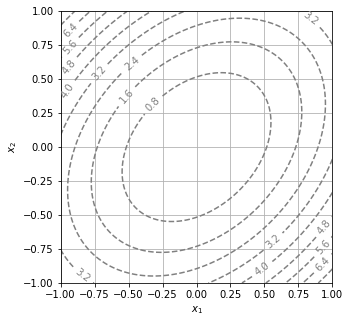

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

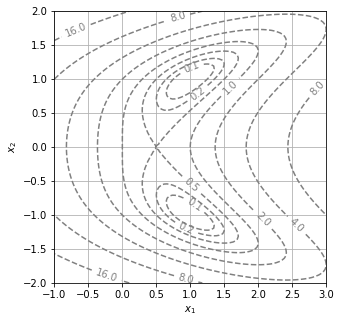

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

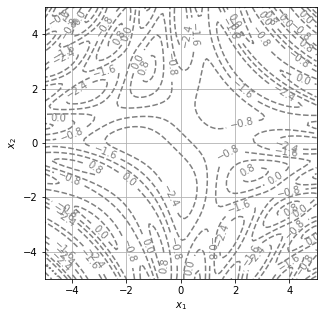

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 10**(-5)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    
    for i in range(N):
        J_F=J(F)
        tab=J_F(x0,y0)
        #print(tab.shape)
        tab_inv=np.linalg.inv(tab)
        #print( np.dot(tab_inv, F(x0,y0) ).shape )
        x,y=x0- np.dot(tab_inv, F(x0,y0) )[0]   , y0 - np.dot(tab_inv, F(x0,y0) )[1] 
        #print(x-x0,y-y0)
        
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [15]:
def F2(x,y):
    return( np.array( [ f2(x,y)-0.5 , x-y ]) ) 
def F1(x,y):
    return( np.array( [ f1(x,y)-0.8 , x-y ]) ) 

def F3(x,y):
    return( np.array( [ f3(x,y)-0.8 , x-y ]) ) 
Newton(F1,0.8,0.8)

#On fait varier le point de départ :






(0.4472135954999579, 0.4472135954999579)

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

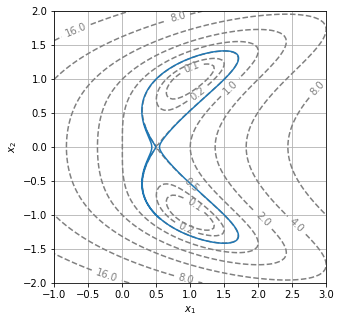

In [16]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    tab=np.empty( (2,N) )
    #print(tab[:,0].shape) # Shape (2,)
    tab[:,0]=np.array([x0,y0])
    x,y=x0,y0
    for k in range(1,N):
        grad_f=grad(f)
        
        gradient=grad_f(x,y)
        if np.isclose(gradient[0],0.) :
            x=x+delta
            y=y
        
        else :
            sol1y= - delta/np.sqrt(1+ (gradient[1]/gradient[0])**2 )
            sol1x= -(gradient[1]/gradient[0]) * sol1y
            #print(gradient)
            normegrad= np.sqrt( gradient[0]**2 + gradient[1]**2)
            norme=np.sqrt(sol1x**2+sol1y**2)
            #print(np.dot(gradient, np.array([sol1x,sol1y])))
            #print(np.linalg.det(np.array( [ [gradient[0]/normegrad, sol1x/norme ], [gradient[1]/normegrad, sol1y/norme ]])))
            if np.isclose(np.linalg.det(np.array( [ [gradient[0]/normegrad, sol1x/norme ], [gradient[1]/normegrad, sol1y/norme ]])),1.) : 
                    #L'idée serait de regarde la matrice de
                  #passage de la base orthonormée canonique dans celle crée et de voir si de déterminant +1, 
                    #sinon on change la sol, car ça veut dire qu'on a une indirecte, et donc qu'un part vers la gauche
                    
                x=sol1x+x
                y=sol1y+y
        
            else: 
                x=-sol1x+x
                y=-sol1y+y
        tab[:,k]=np.array([x,y])
    
    return (tab)

x0,y0=Newton(F2,0.8,0.8)
tab=level_curve(f2,x0,y0,delta=0.001,N=10000) #On augmente la précision et le nombre de points pour que ça suive bien

X=tab[0,:]
Y=tab[1,:]

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(X,Y)

    
#CA MARCHE, mais on fait plusieurs tours







### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

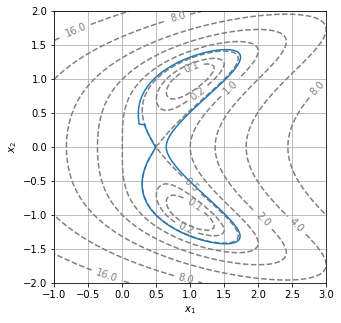

In [17]:
def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    tab=np.empty( (2,N) )
    #print(tab[:,0].shape) # Shape (2,)
    tab[:,0]=np.array([x0,y0])
    x,y=x0,y0
    for k in range(1,N):
        grad_f=grad(f)
        gradient=grad_f(x,y)
        if k>= 10 and np.abs(y - tab[1,0]) <= delta and np.abs(x-tab[0,0]) <= 10*delta :  #A la zeub, marche pour f1, f2
            tab[0,k:]=tab[0,0]
            tab[1,k:]=tab[1,0]
            return(tab)
        else:
            if np.isclose(gradient[0],0.) :
                x=x+delta
                y=y
            else :
                sol1y= - delta/np.sqrt(1+ (gradient[1]/gradient[0])**2 )
                sol1x= -(gradient[1]/gradient[0]) * sol1y
                normegrad= np.sqrt( gradient[0]**2 + gradient[1]**2)
                norme=np.sqrt(sol1x**2+sol1y**2)
                if np.isclose(np.linalg.det(np.array( [ [gradient[0]/normegrad, sol1x/norme ], [gradient[1]/normegrad, sol1y/norme ]])),1.) : 
                    x=sol1x+x
                    y=sol1y+y
        
                else: 
                    x=-sol1x+x
                    y=-sol1y+y
            tab[:,k]=np.array([x,y])
    
    return (tab)


x0,y0=Newton(F2,0.8,0.8)
tab=level_curve2(f2,x0,y0,delta=0.01,N=10000) #On augmente la précision et le nombre de points pour que ça suive bien

X=tab[0,:]
Y=tab[1,:]

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(X,Y);





**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [18]:
#A faire de jolis dessins, notamment avec f3 mais je sais pas si ça marche (utiliser F3 pour Newton)

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [32]:
def F(x,y):
    return( np.array( [ cercle(x,y)-1. , x-y ]) ) 

def area_squares(f,c,h):
    a,b=Newton(F,1.,0.) #Comment choisir x0, y0 ?
    K=level_curve2(f,a,b)
    np.vectorize(f)
    #On regarde les bornes du gros carré :
    tabmax=K.max(axis=1) #On obtient un truc de taille (2,)
    tabmin=K.min(axis=1) #Idem
    
    #cote= max( abs(tabmax[0]-tabmin[0]),abs(tabmax[1]-tabmin[1]) )
    
    L=[ [[tabmin[0]+k*h/2,tabmin[1]+i*h/2 ] for k in range(1,int(abs(tabmax[0]-tabmin[0]))+1 )] for i in range(1,int(tabmax[1]-tabmin[1])+1) ]
    tabcarre=np.array(L)
    tabcarre.reshape( (2,-1))
    tab2= f(tab)
    tab2=tab2[tab2<=c]
    tot=tab2.sum()
    return(tot*h**2)
    
    # L'aire d'une cellule est Airecarré/h**2
    #Il faudrait faire un tableau avec toutes les positions de tous les centres, puis de le parcourir et de trouver
    #une condition pour savoir si c'est dedans, ie si f(x,y) <= c, il suffit d'évaluer.

def cercle(x,y):
    if y>=0:
        return(np.sqrt(x**2+y**2))
    else:
        return(-np.sqrt(x**2+y**2))

print(area_squares(cercle,1.,0.1) )
    
    
    
    
    
    
    
    
    
        
    
    

TypeError: cercle() missing 1 required positional argument: 'y'

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)